In [1]:
import warnings

warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Accessing the Electricity Demand Dataset

This notebook assumes that you have downloaded the [electricity-demand](https://huggingface.co/datasets/EDS-lab/electricity-demand/tree/main/data) dataset from HuggingFace. To execute this notebook create a folder `data/electricity-demand/` and download the 3 files into it.

In [2]:
from enfobench.datasets import ElectricityDemandDataset

ds = ElectricityDemandDataset("../data/electricity-demand")

In [3]:
unique_ids = ds.metadata_subset.list_unique_ids()
unique_id = unique_ids[0]

In [4]:
target, weather, metadata = ds.get_data_by_unique_id(unique_id)

In [5]:
target.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 25029 entries, 2012-09-24 12:00:00 to 2014-02-28 00:00:00
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       25028 non-null  float64
dtypes: float64(1)
memory usage: 391.1 KB


In [6]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 12853 entries, 2012-09-17 12:00:00 to 2014-03-07 00:00:00
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   temperature_2m              12853 non-null  float32
 1   relative_humidity_2m        12853 non-null  float32
 2   dew_point_2m                12853 non-null  float32
 3   apparent_temperature        12853 non-null  float32
 4   precipitation               12853 non-null  float32
 5   rain                        12853 non-null  float32
 6   snowfall                    12853 non-null  float32
 7   snow_depth                  12853 non-null  float32
 8   weather_code                12853 non-null  float32
 9   pressure_msl                12853 non-null  float32
 10  surface_pressure            12853 non-null  float32
 11  cloud_cover                 12853 non-null  float32
 12  cloud_cover_low             12853 non-null  float32
 

In [7]:
from enfobench.datasets.utils import create_perfect_forecasts_from_covariates

In [8]:
perfect_weather_forecasts = create_perfect_forecasts_from_covariates(
    weather[['temperature_2m', 'relative_humidity_2m', 'wind_speed_10m', 'wind_direction_10m', 'cloud_cover']],
    start=pd.Timestamp("2013-01-01T00:00:00"),
    horizon=pd.Timedelta("4 days"),
    step=pd.Timedelta("24 hour"),
)

In [9]:
perfect_weather_forecasts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41419 entries, 0 to 41418
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   cutoff_date           41419 non-null  datetime64[ns]
 1   timestamp             41419 non-null  datetime64[us]
 2   temperature_2m        41419 non-null  float32       
 3   relative_humidity_2m  41419 non-null  float32       
 4   wind_speed_10m        41419 non-null  float32       
 5   wind_direction_10m    41419 non-null  float32       
 6   cloud_cover           41419 non-null  float32       
dtypes: datetime64[ns](1), datetime64[us](1), float32(5)
memory usage: 1.4 MB


# Create Dataset

In [10]:
from enfobench import Dataset

dataset = Dataset(
    target=target,
    past_covariates=weather,
    future_covariates=perfect_weather_forecasts,
    metadata=metadata,
)

# Perform crossvalidation via server

In [37]:
from enfobench.evaluation import ForecastClient

client = ForecastClient(port=3000)

In [38]:
client.info()

ModelInfo(name='Darts.NaiveMean', authors=[{'name': 'Attila Balint', 'email': 'attila.balint@kuleuven.be'}], type='point', params={})

In [39]:
from enfobench.evaluation import cross_validate

crossval_df = cross_validate(
    client,
    dataset,
    start_date=pd.Timestamp("2013-06-01T10:00:00"),
    end_date=pd.Timestamp("2013-07-01T00:00:00"),
    horizon=pd.Timedelta("38 hours"),
    step=pd.Timedelta("1 day"),
    level=90,
)

100%|██████████| 29/29 [00:02<00:00, 12.98it/s]


In [40]:
crossval_df.head()

,cutoff_date,timestamp,yhat,y
0,2013-06-01 10:00:00,2013-06-01 10:30:00,0.202868,0.389
1,2013-06-01 10:00:00,2013-06-01 11:00:00,0.202868,0.094
2,2013-06-01 10:00:00,2013-06-01 11:30:00,0.202868,0.170
3,2013-06-01 10:00:00,2013-06-01 12:00:00,0.202868,0.081
4,2013-06-01 10:00:00,2013-06-01 12:30:00,0.202868,0.318


In [41]:
import matplotlib.animation as animation

plt.rcParams["animation.html"] = "jshtml"

In [42]:
plt.ioff()
fig, ax = plt.subplots(figsize=(12, 5))

cutoff_dates = crossval_df.cutoff_date.unique()


def animate_forecast(t):
    plt.cla()

    cutoff_date = cutoff_dates[t]
    history = dataset.get_history(cutoff_date)
    forecast = (
        crossval_df.loc[crossval_df.cutoff_date == cutoff_date].set_index("timestamp").drop(columns=["cutoff_date"])
    )

    ax.plot(history.index, history.y)
    ax.plot(forecast.index, forecast.yhat)
    ax.set_xlim(cutoff_dates[0] - pd.Timedelta('7D'), crossval_df.timestamp.max())
    ax.set_ylabel("Energy (kWh)")
    ax.set_title(f"Predicted energy consumption at {cutoff_date}", fontsize="large", loc="left")


ani = animation.FuncAnimation(fig, animate_forecast, frames=len(cutoff_dates))
ani

In [43]:
plt.ion()
plt.close()

# Metrics

In [44]:
from enfobench.evaluation import evaluate_metrics
from enfobench.evaluation.metrics import mean_absolute_error, mean_bias_error

In [45]:
overall_metrics = evaluate_metrics(crossval_df, metrics={"MAE": mean_absolute_error, "MBE": mean_bias_error})
overall_metrics

,MAE,MBE,weight
0,0.122082,0.022403,1.0


In [46]:
metrics_per_cutoff = evaluate_metrics(
    crossval_df,
    metrics={"MAE": mean_absolute_error, "MBE": mean_bias_error},
    groupby="cutoff_date",
)
metrics_per_cutoff.head()

100%|██████████| 29/29 [00:00<00:00, 297.25it/s]


,cutoff_date,MAE,MBE,weight
0,2013-06-01 10:00:00,0.106976,0.039737,1.0
1,2013-06-02 10:00:00,0.111781,0.048734,1.0
2,2013-06-03 10:00:00,0.129792,0.025933,1.0
3,2013-06-04 10:00:00,0.132067,0.021946,1.0
4,2013-06-05 10:00:00,0.125143,0.004769,1.0


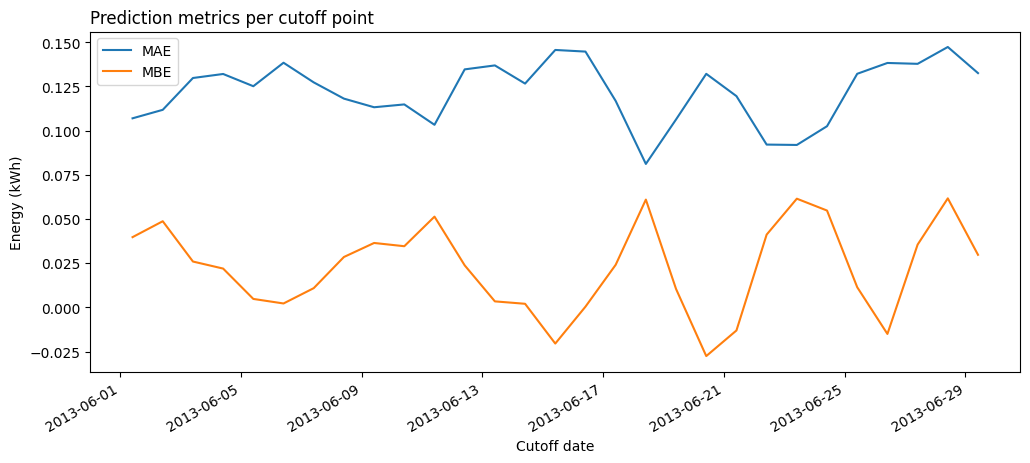

In [47]:
fig, ax = plt.subplots(figsize=(12, 5))
metrics_per_cutoff.set_index("cutoff_date")[["MAE", "MBE"]].plot(ax=ax)
ax.set_xlabel("Cutoff date")
ax.set_ylabel("Energy (kWh)")
ax.set_title("Prediction metrics per cutoff point", fontsize="large", loc="left")
plt.show()